### neo cognitron
#### Zernab Saeed

In [16]:
import os
import re
import gc
import numpy as np
import collections
from PIL import Image
from textwrap import wrap
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img, img_to_array

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add

In [17]:
def clean_description(desc, stopwords):
    cleaned = desc.lower()
    cleaned = re.sub('[^a-z]',' ',cleaned)
    tokens = cleaned.split(' ')
    cleaned = ' '.join([w for w in tokens if w not in stopwords and len(w)>1])
  
    return cleaned

In [18]:
def get_vocabulary(dictionary):
    vocab = set()

    for desc_list in dictionary.values():
        for desc in desc_list:
            words = desc.split(' ')
            for word in words:
                vocab.add(word)

    return vocab

In [19]:
with open('/home/pk3j/s21-team4-project/xception_example.txt', 'r') as f:
  all_desc = f.read().split('\n')

In [20]:
# Some sample data
all_desc[:5]

['image_0.JPEG\tparakeet on laptop',
 'image_1.JPEG\tdog with sheep',
 'image_2.JPEG\tcow udder',
 'image_3.JPEG\ttwo puppies playing',
 'image_4.JPEG\tEgyptian cat looking at camera']

In [21]:
stopwords = ['on', 'with', 'looking', 'the', 'was']

In [22]:
all_dict = dict()

for desc in all_desc:
    if len(desc) < 1:
        continue
    file_name, file_desc = desc.split('\t')[0].split('.')[0], desc.split('\t')[1]
  
    if file_name not in all_dict.keys():
        all_dict[file_name] = []

    cleaned_desc = clean_description(file_desc, stopwords)
    cleaned_desc = 'startseq ' + cleaned_desc + ' endseq'

    all_dict[file_name].append(cleaned_desc)
    
    

In [23]:
vocab = get_vocabulary(all_dict)

In [24]:
print('Total images:', len(all_dict))
print('Total vocabulary without stopwords:', len(vocab))

Total images: 101
Total vocabulary without stopwords: 171


In [25]:
all_sent_list = [item.strip('startseq').strip('endseq').strip(' ') for sublist in list(all_dict.values()) for item in sublist]

In [26]:
all_sent_len = [len(sent) for sent in all_sent_list]

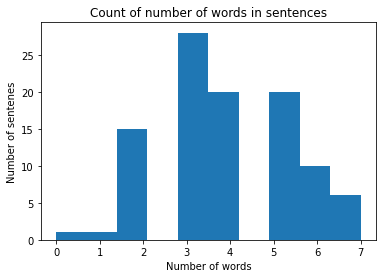

In [27]:
plt.hist([len(sentence.split()) for sentence in all_sent_list])
plt.xlabel('Number of words')
plt.ylabel('Number of sentenes')
plt.title('Count of number of words in sentences')
plt.show()

In [28]:
avg_sent_len = int(np.mean([len(sentence.split()) for sentence in all_sent_list]))
avg_sent_len

3

In [29]:
words = [w for a in all_sent_list for w in a.split(' ')]

In [30]:

counts = collections.Counter(words)
most_common = counts.most_common()
most_common[:15]

[('cat', 34),
 ('dog', 33),
 ('in', 18),
 ('and', 13),
 ('black', 12),
 ('white', 11),
 ('to', 9),
 ('camera', 8),
 ('trying', 8),
 ('two', 7),
 ('brown', 7),
 ('at', 6),
 ('sheep', 5),
 ('cow', 5),
 ('cute', 5)]

In [31]:
keys = [tupl[0] for tupl in most_common][:15]
values = [tupl[1] for tupl in most_common][:15]

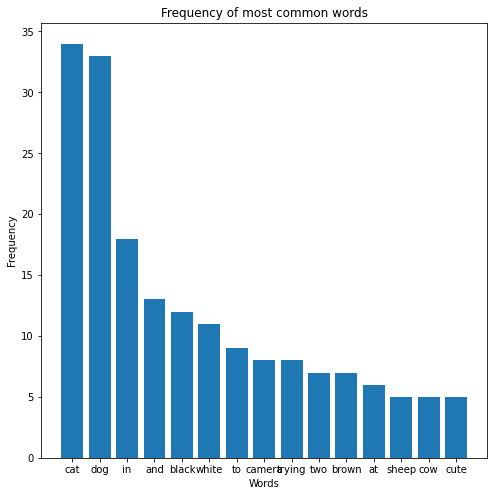

In [32]:

plt.figure(figsize=(8, 8))
plt.bar(keys, values)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of most common words')
plt.show()

In [33]:
lengths = set()
for cap_list in all_dict.values():
  lengths.add(len(cap_list))

print('Number of captions for each image: ', lengths)

Number of captions for each image:  {1}


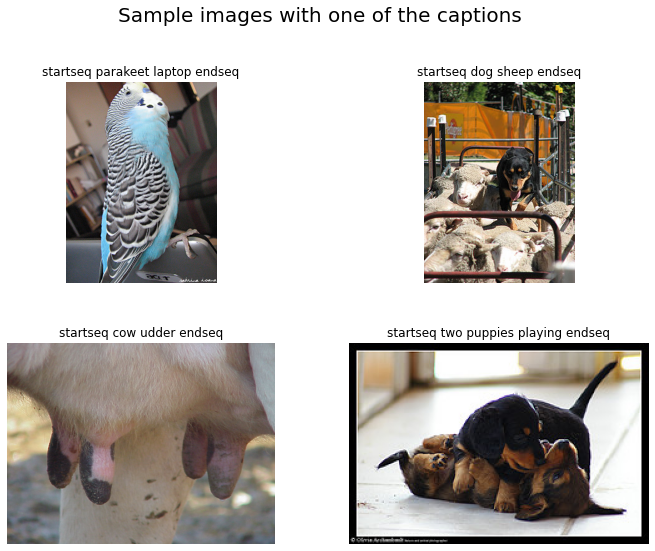

In [58]:
fig = plt.figure()
fig.suptitle('Sample images with one of the captions', fontsize=20)

zoom = 2
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.imshow(plt.imread('xception_example/images/' +list(all_dict.keys())[i-1]+'.JPEG'))
    title = ax.set_title('\n'.join(wrap(all_dict.get(list(all_dict.keys())[i-1])[0], 60)))
    fig.tight_layout(h_pad=2)
    title.set_y(1.05)
    plt.axis('off')
    fig.subplots_adjust(top=0.85, hspace=0.3)

plt.show()

In [59]:
#xcep = Xception(include_top=False, pooling='avg')
model = Xception(weights='imagenet') 

In [60]:
#xcep.summary()
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [61]:
predictions = dict()

for dirpath, dirname, files in os.walk('xception_example/images'):
    for filename in tqdm(files):
        img_path = os.path.join(dirpath, filename)
    if os.path.isfile(img_path):
        img = Image.open(img_path)
        img = img.resize((299,299))
        img = np.expand_dims(img, axis=0)
        img = img/127.5
        img = img - 1.0

        predictions[filename.split('\n')[0]] = xcep.predict(img)

  0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'xcep' is not defined

In [62]:
predictions = dict()

for dirpath, dirname, files in os.walk('xception_example/images'):
    for filename in tqdm(files):
        img_path = os.path.join(dirpath, filename)
    if os.path.isfile(img_path):
        img = Image.open(img_path)
        img = img.resize((299,299))
        img = np.expand_dims(img, axis=0)
        img = img/127.5
        img = img - 1.0

        predictions[filename.split('\n')[0]] = model.predict(img)

  0%|          | 0/100 [00:00<?, ?it/s]

In [63]:
#print('Number of extracted features:', len(predictions.get(list(predictions.keys())[0])[0]))

In [64]:
print('Number of extracted features:', len(predictions.get(list(predictions.keys())[0])[0]))

Number of extracted features: 1000


In [65]:
def create_list(dictionary):
    final_list = []
    
    for desc_list in dictionary.values():
        for desc in desc_list:
            final_list.append(desc)

    return final_list


In [66]:
def fit_tokenizer(dictionary):
    desc_list = create_list(dictionary)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [67]:
def convert_to_input(tokens, pos, im_name, max_len, vocab_len, tokenizer, img_predictions):
    inp = tokens[:pos]
    out = tokens[pos]
    inp = pad_sequences(sequences=[inp], maxlen=max_len)[0]
    out = to_categorical(y=[out], num_classes=vocab_len, dtype='bool')[0]
  
    return img_predictions.get(im_name)[0], inp, out

In [70]:
def convert_all_to_input(dictionary, max_len, vocab_len, tokenizer, img_predictions):
  
  X_1 = list()
  X_2 = list()
  y = list()

  for im_name, descriptions in tqdm(dictionary.items()):
    if im_name in img_predictions.keys():
      for desc in descriptions:
          tokens = tokenizer.texts_to_sequences([desc])[0]
          for i in range(1, len(tokens)):
              _X_1, _X_2, _y = convert_to_input(tokens, i, im_name, max_len, vocab_len, tokenizer, img_predictions)
              X_1.append(_X_1)
              X_2.append(_X_2)
              y.append(_y)
  return np.array(X_1), np.array(X_2), np.array(y)

In [71]:
tokenizer = fit_tokenizer(all_dict)

In [72]:
vocab_len = len(tokenizer.index_word) + 1
vocab_len

171

In [73]:
max_len = len(max(create_list(all_dict)))
max_len

39

In [74]:
cnn_len = predictions[list(predictions.keys())[0]].shape[1]
cnn_len

1000

In [75]:
X_1, X_2, y = convert_all_to_input(all_dict, max_len, vocab_len, tokenizer, predictions)


  0%|          | 0/101 [00:00<?, ?it/s]

In [76]:
def shuffle_arrays(arrays, set_seed=-1):
   # """Shuffles arrays in-place, in the same order, along axis=0

  #  Parameters:
  #  -----------
   # arrays : List of NumPy arrays.
   # set_seed : Seed value if int >= 0, else seed is random.
    #"""
    assert all(len(arr) == len(arrays[0]) for arr in arrays)
    seed = np.random.randint(0, 2**(32 - 1) - 1) if set_seed < 0 else set_seed

    for arr in arrays:
        rstate = np.random.RandomState(seed)
        rstate.shuffle(arr)

In [77]:
shuffle_arrays([X_1, X_2, y])

In [78]:
def create_model(cnn_len, max_len, vocab_len):
    cnn_in = Input(shape=(cnn_len,))
    cnn_x = Dropout(0.5)(cnn_in)
    cnn_out = Dense(units=256, activation='relu')(cnn_x)

    lstm_in = Input(shape=(max_len,))
    lstm_x = Embedding(vocab_len, 256, mask_zero=True)(lstm_in)
    lstm_x = Dropout(0.5)(lstm_x)
    lstm_out = LSTM(256)(lstm_x)

    combined = add([cnn_out, lstm_out])
    combined_x = Dense(units=256, activation='relu')(combined)
    output = Dense(units=vocab_len, activation='softmax')(combined_x)

    model = Model(inputs=[cnn_in, lstm_in], outputs=output)

    return model


In [79]:
model = create_model(cnn_len, max_len, vocab_len)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
            loss=tf.keras.losses.categorical_crossentropy, 
            metrics=[tf.keras.metrics.categorical_accuracy])

In [80]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 39)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 39, 256)      43776       input_5[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1000)         0           input_4[0][0]                    
______________________________________________________________________________________________

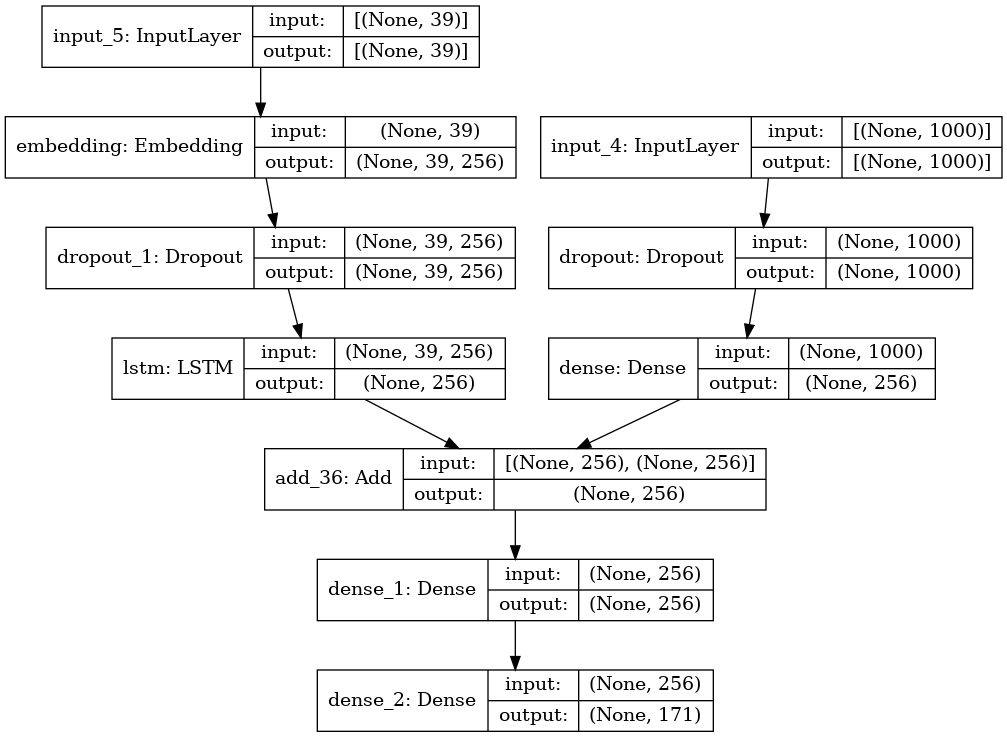

In [81]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [105]:
# Train 4096 rows at a time to avoid memory overflow.

batch_size=256

#for i in (range(0, len(X_1), batch_size)):
 #   model.fit(x=[X_1[i:i+batch_size], X_2[i:i+batch_size]], y=y[i:i+batch_size], epochs=20, batch_size=256)
    
#for i in tqdm(range(0, len(X_1), batch_size)):
model.fit([X_1, X_2], y, epochs = 50, batch_size = 256)

Epoch 1/50


ValueError: Expect x to be a non-empty array or dataset.